In [2]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as pdr

In [2]:
def filter_dunder(any_obj):
    temp_list = dir(any_obj)
    date_obj_meth_attr = []
    for i in temp_list:
        if i[0:2] != '__':
            date_obj_meth_attr.append(i)
    date_obj_meth_attr = {'meth_attr':date_obj_meth_attr}
    return pd.DataFrame(date_obj_meth_attr)

In [3]:
time_stamp = pd.Timestamp(dt.datetime(2021,12,25))

In [4]:
filter_dunder(time_stamp)

,meth_attr
0,_date_repr
1,_repr_base
2,_round
3,_short_repr
4,_time_repr
...,...
75,value
76,week
77,weekday
78,weekofyear


In [5]:
print(time_stamp.year)
print(time_stamp.month)
print(time_stamp.day)
print(time_stamp.day_name())

2021
12
25
Saturday


In [6]:
print(time_stamp)

2021-12-25 00:00:00


In [7]:
period = pd.Period('2021-8'); period

Period('2021-08', 'M')

In [8]:
period_2 = pd.Period('2021-8-28', 'D'); period_2

Period('2021-08-28', 'D')

In [9]:
print(period + 2)

2021-10


In [10]:
print(period_2 - 10)

2021-08-18


## Sequence of Time

Each object in the ```date_range``` is a ```Timestamp``` object.

In [11]:
index = pd.date_range(start = '2010-12', end = '2021-12', freq = 'M')
index

DatetimeIndex(['2010-12-31', '2011-01-31', '2011-02-28', '2011-03-31',
               '2011-04-30', '2011-05-31', '2011-06-30', '2011-07-31',
               '2011-08-31', '2011-09-30',
               ...
               '2021-02-28', '2021-03-31', '2021-04-30', '2021-05-31',
               '2021-06-30', '2021-07-31', '2021-08-31', '2021-09-30',
               '2021-10-31', '2021-11-30'],
              dtype='datetime64[ns]', length=132, freq='M')

In [12]:
index.to_period()

PeriodIndex(['2010-12', '2011-01', '2011-02', '2011-03', '2011-04', '2011-05',
             '2011-06', '2011-07', '2011-08', '2011-09',
             ...
             '2021-02', '2021-03', '2021-04', '2021-05', '2021-06', '2021-07',
             '2021-08', '2021-09', '2021-10', '2021-11'],
            dtype='period[M]', length=132, freq='M')

In [13]:
index_2 = pd.date_range(start= '2021-12-1', periods = 10)
for day in index_2:
    print(str(day.day) + ':' + day.day_name())

1:Wednesday
2:Thursday
3:Friday
4:Saturday
5:Sunday
6:Monday
7:Tuesday
8:Wednesday
9:Thursday
10:Friday


In [14]:
index_2

DatetimeIndex(['2021-12-01', '2021-12-02', '2021-12-03', '2021-12-04',
               '2021-12-05', '2021-12-06', '2021-12-07', '2021-12-08',
               '2021-12-09', '2021-12-10'],
              dtype='datetime64[ns]', freq='D')

## Create a Time Series

In [15]:
time_series = pd.DataFrame({'Time':index})

In [16]:
time_series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Time    132 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.2 KB


In [17]:
data = np.random.randn(len(index), 2)

In [18]:
time_series = pd.DataFrame(data = data, index = index, columns =['Series_1', 'Series_2'])

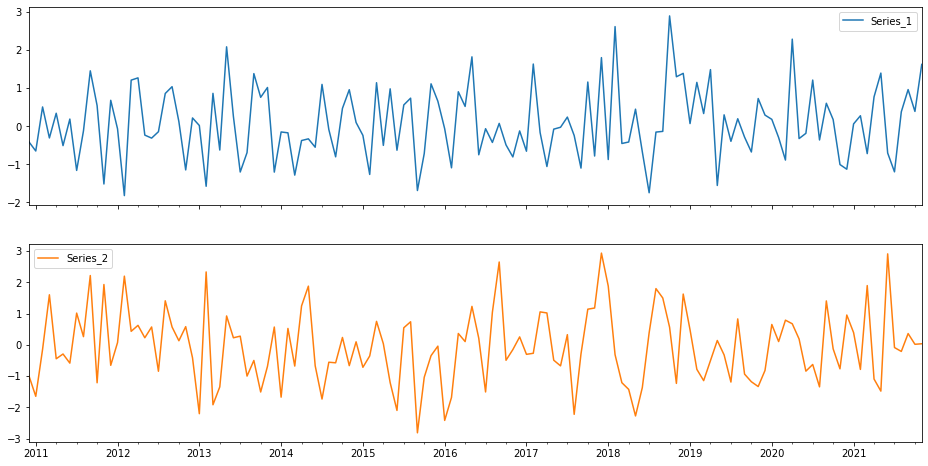

In [19]:
time_series.plot(figsize=(16, 8), subplots=True); plt.show()

In [20]:
tesla_stockp = pdr.data.DataReader(name = 'TSLA', data_source = 'yahoo', start = '2018-1-1', end = '2021-12-1')

In [21]:
tesla_stockp.head(10)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-01-02,64.421997,62.200001,62.400002,64.106003,21761000.0,64.106003
2018-01-03,65.050003,63.110001,64.199997,63.450001,22607500.0,63.450001
2018-01-04,63.709999,61.136002,62.574001,62.924000,49731500.0,62.924000
2018-01-05,63.448002,62.400002,63.324001,63.316002,22956000.0,63.316002
2018-01-08,67.403999,63.099998,63.200001,67.281998,49297000.0,67.281998
2018-01-09,67.760002,65.480003,67.031998,66.737999,35733000.0,66.737999
2018-01-10,67.400002,66.000000,66.440002,66.959999,21549500.0,66.959999
2018-01-11,68.961998,66.652000,67.047997,67.589996,33227500.0,67.589996
2018-01-12,68.082001,66.734001,67.725998,67.244003,24125500.0,67.244003


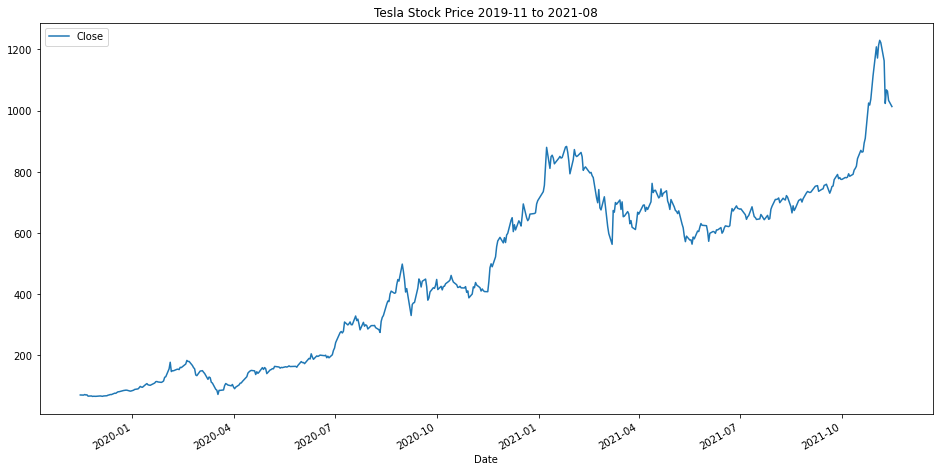

In [22]:
tesla_stockp.loc['2019-11-15':'2021-11-15', ['Close']].plot(figsize=(16, 8), 
                                                            title = 'Tesla Stock Price 2019-11 to 2021-08'); plt.show()

Upsampling to including non-trade days, such as weekends.

In [23]:
tesla_stockp.asfreq('D').head(10)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-01-02,64.421997,62.200001,62.400002,64.106003,21761000.0,64.106003
2018-01-03,65.050003,63.110001,64.199997,63.450001,22607500.0,63.450001
2018-01-04,63.709999,61.136002,62.574001,62.924000,49731500.0,62.924000
2018-01-05,63.448002,62.400002,63.324001,63.316002,22956000.0,63.316002
2018-01-06,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-07,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-08,67.403999,63.099998,63.200001,67.281998,49297000.0,67.281998
2018-01-09,67.760002,65.480003,67.031998,66.737999,35733000.0,66.737999
2018-01-10,67.400002,66.000000,66.440002,66.959999,21549500.0,66.959999


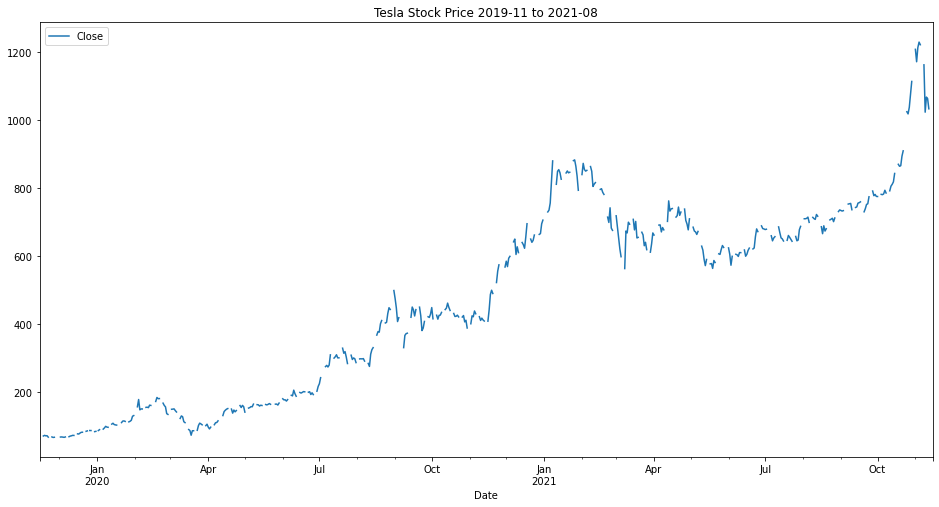

In [24]:
tesla_stockp.asfreq('D').loc['2019-11-15':'2021-11-15', ['Close']].plot(figsize=(16, 8), 
                                                            title = 'Tesla Stock Price 2019-11 to 2021-08'); plt.show()

## Compare Each Years Data

In [34]:
tesla_prices = pd.DataFrame()
for year in ['2018', '2019', '2020', '2021']:
    price_per_year = tesla_stockp.loc[year, ['Close']].reset_index(drop=True)
    price_per_year.rename(columns={'Close':year+' close'}, inplace=True)
    tesla_prices = pd.concat([tesla_prices, price_per_year], axis=1)
    
tesla_prices.head()

,2018 close,2019 close,2020 close,2021 close
0,64.106003,62.023998,86.052002,729.770020
1,63.450001,60.071999,88.601997,735.109985
2,62.924000,63.537998,90.307999,755.979980
3,63.316002,66.991997,93.811996,816.039978
4,67.281998,67.070000,98.428001,880.020020


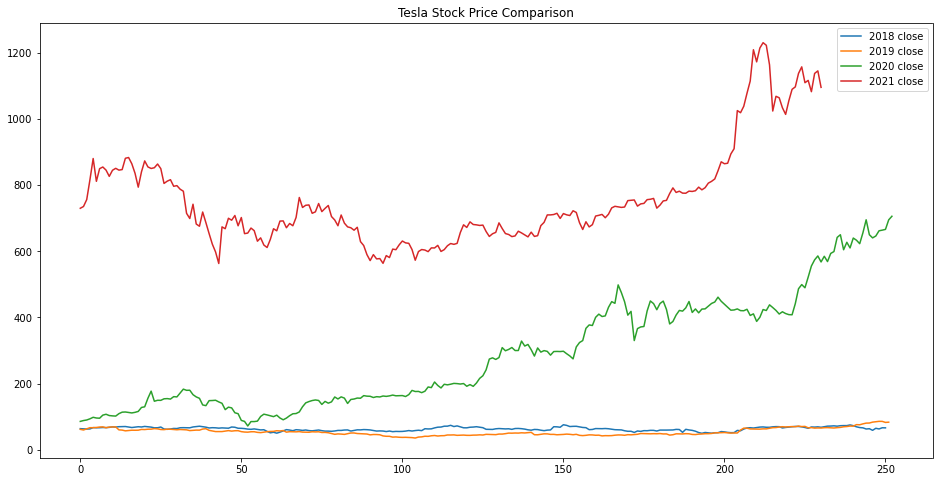

In [38]:
tesla_prices.plot(figsize=(16, 8), title ='Tesla Stock Price Comparison'); plt.show()

## Resampling

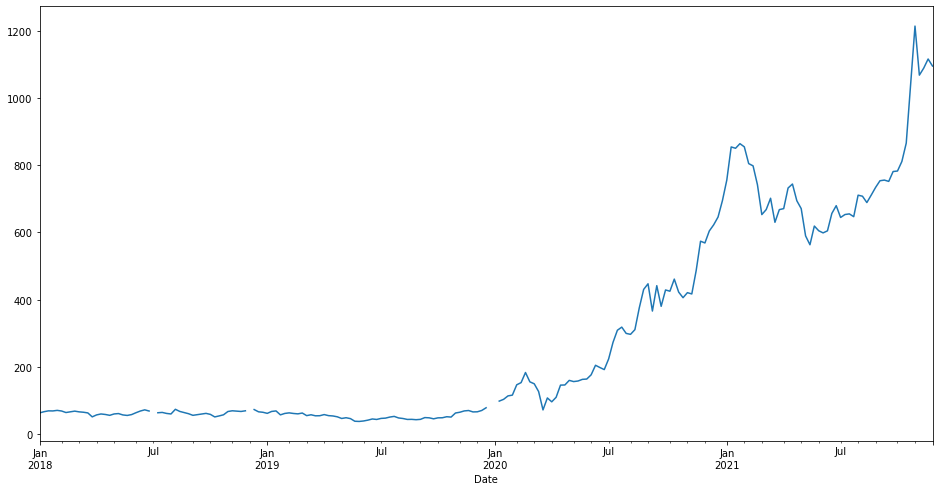

In [54]:
tesla_stockp['Close'].asfreq('W-Wed').plot(figsize = (16, 8)); plt.show()

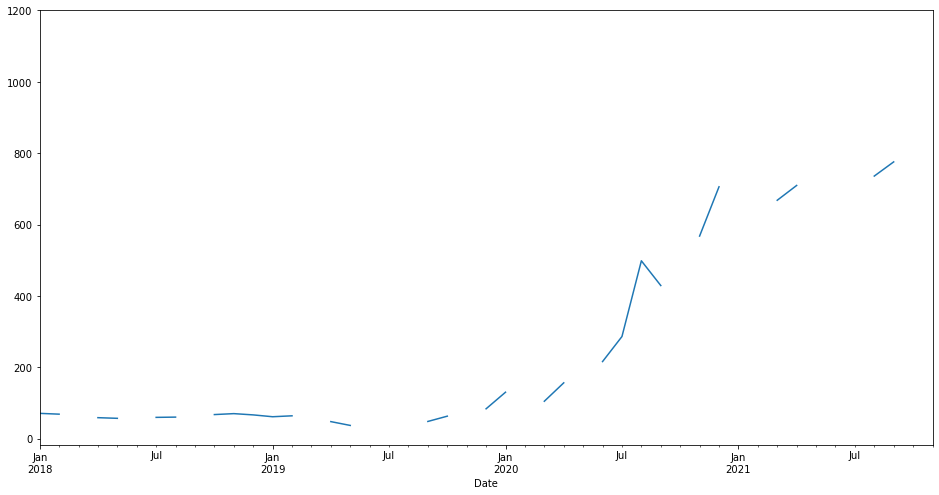

In [55]:
tesla_stockp['Close'].asfreq('M').plot(figsize = (16, 8)); plt.show()

## Lagged Variable

In [58]:
tesla_stockp['Lag_1'] = tesla_stockp['Close'].shift()
tesla_stockp['Daily Change'] = tesla_stockp['Close'].div(tesla_stockp['Lag_1'])

In [59]:
tesla_stockp.head()

,High,Low,Open,Close,Volume,Adj Close,Lag_1,Daily Change
Date,,,,,,,,
2018-01-02,64.421997,62.200001,62.400002,64.106003,21761000.0,64.106003,NaN,NaN
2018-01-03,65.050003,63.110001,64.199997,63.450001,22607500.0,63.450001,64.106003,0.989767
2018-01-04,63.709999,61.136002,62.574001,62.924000,49731500.0,62.924000,63.450001,0.991710
2018-01-05,63.448002,62.400002,63.324001,63.316002,22956000.0,63.316002,62.924000,1.006230
2018-01-08,67.403999,63.099998,63.200001,67.281998,49297000.0,67.281998,63.316002,1.062638


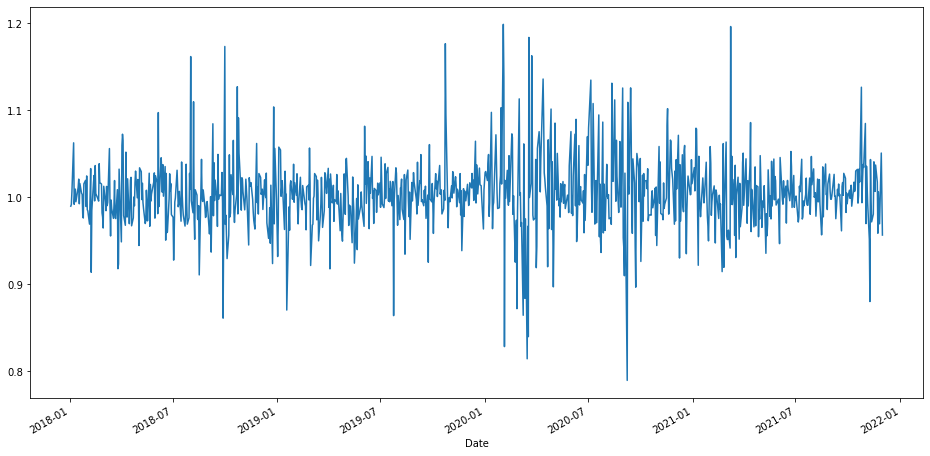

In [61]:
tesla_stockp['Daily Change'].plot(figsize = (16, 8)); plt.show()

## Growth Rate

In [62]:
tesla_stockp['change_pct'] = tesla_stockp['Close'].pct_change()

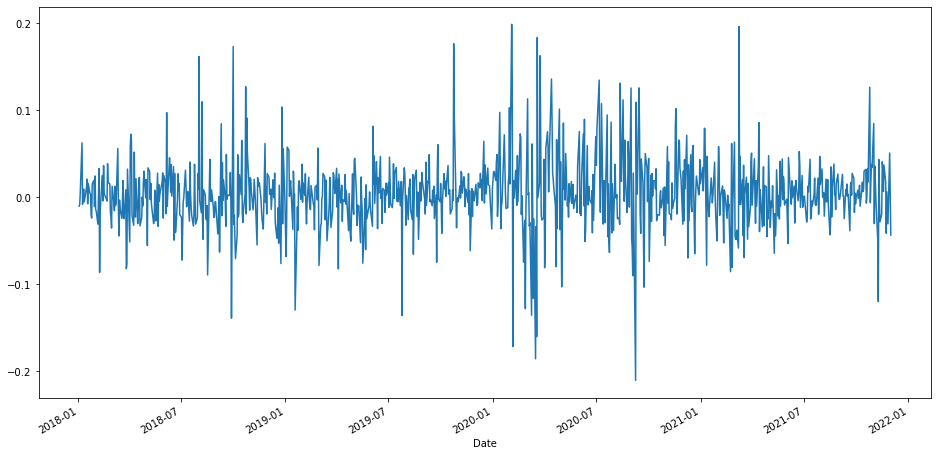

In [63]:
tesla_stockp['change_pct'].plot(figsize = (16, 8)); plt.show()

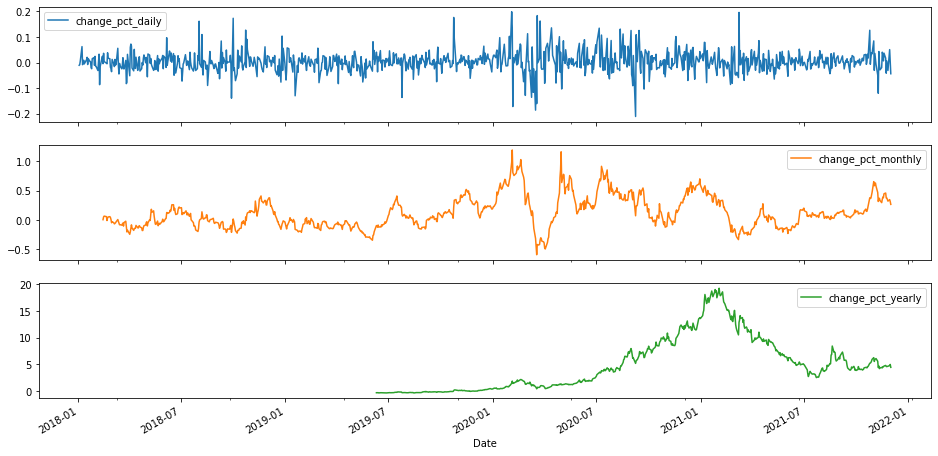

In [81]:
tesla_stockp['change_pct_daily'] = tesla_stockp['Close'].pct_change()
tesla_stockp['change_pct_monthly'] = tesla_stockp['Close'].pct_change(periods=30)
tesla_stockp['change_pct_yearly'] = tesla_stockp['Close'].pct_change(periods=360)
tesla_stockp[['change_pct_daily', 'change_pct_monthly', 'change_pct_yearly']]\
.plot(subplots=True, figsize = (16, 8)); plt.show()

In [103]:
# SP500, Gold, Crude oil, Gold, Bitcoin, Nikkei 225
assets_tickers =  ['^GSPC', 'GC=F', 'CL=F', 'BTC-USD', '^N225']
legends = ['SP500', 'Gold', 'Crude oil', 'Gold', 'Bitcoin', 'Nikkei 225']
start_date = '2010-1-1'
end_date = '2021-12-1'
assets_price = pdr.data.DataReader(name = assets_tickers, data_source = 'yahoo', start = start_date, end = end_date)

In [106]:
normalized_prices = assets_price['Close'].div(assets_price['Close'].iloc[0]).mul(100)

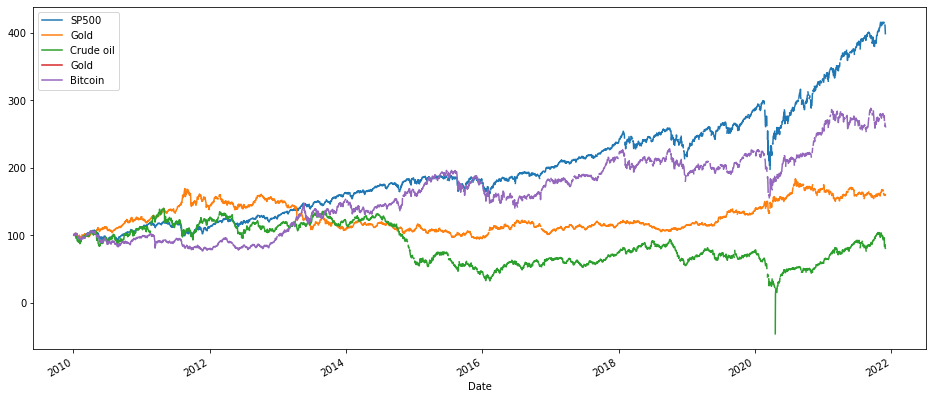

In [107]:
price_plot = normalized_prices.plot(figsize = (16, 7))
price_plot.legend(legends)
plt.show()

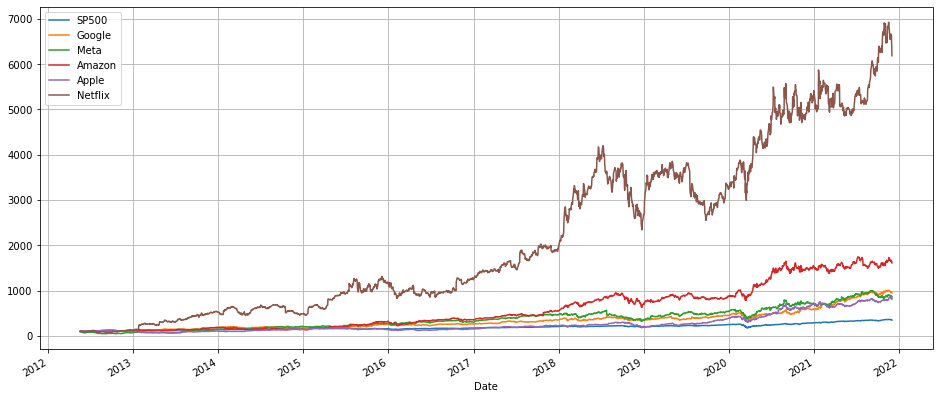

In [121]:
assets_tickers =  ['^GSPC', 'GOOG', 'FB', 'AMZN', 'AAPL', 'NFLX']
legends = ['SP500', 'Google', 'Meta', 'Amazon', 'Apple', 'Netflix']
start_date = '2010-1-1'
end_date = '2021-12-1'
assets_price = pdr.data.DataReader(name = assets_tickers, data_source = 'yahoo', start = start_date, end = end_date).dropna()

price_plot = assets_price['Close'].div(assets_price['Close'].iloc[0]).mul(100).plot(figsize = (16, 7), grid = True)
price_plot.legend(legends)
plt.show()

Make them start from $0$.

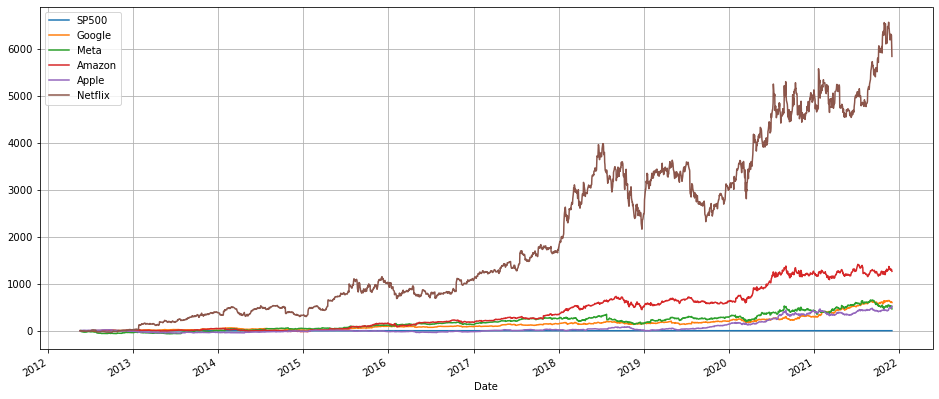

In [122]:
normalized = assets_price['Close'].div(assets_price['Close'].iloc[0]).mul(100)

price_plot = normalized[assets_tickers].sub(normalized['^GSPC'], axis = 0).plot(figsize = (16, 7), grid = True)
price_plot.legend(legends)
plt.show()

## Changing Data Frequency

In [3]:
start = '2021-1-15'
end = '2021-12-20'
dates = pd.date_range(start = start, end = end, freq='M')
dates

DatetimeIndex(['2021-01-31', '2021-02-28', '2021-03-31', '2021-04-30',
               '2021-05-31', '2021-06-30', '2021-07-31', '2021-08-31',
               '2021-09-30', '2021-10-31', '2021-11-30'],
              dtype='datetime64[ns]', freq='M')

In [4]:
monthly = pd.Series(data = np.arange(len(dates)), index = dates); monthly

2021-01-31     0
2021-02-28     1
2021-03-31     2
2021-04-30     3
2021-05-31     4
2021-06-30     5
2021-07-31     6
2021-08-31     7
2021-09-30     8
2021-10-31     9
2021-11-30    10
Freq: M, dtype: int32

In [5]:
weekly_dates = pd.date_range(start = start, end = end, freq='W'); weekly_dates

DatetimeIndex(['2021-01-17', '2021-01-24', '2021-01-31', '2021-02-07',
               '2021-02-14', '2021-02-21', '2021-02-28', '2021-03-07',
               '2021-03-14', '2021-03-21', '2021-03-28', '2021-04-04',
               '2021-04-11', '2021-04-18', '2021-04-25', '2021-05-02',
               '2021-05-09', '2021-05-16', '2021-05-23', '2021-05-30',
               '2021-06-06', '2021-06-13', '2021-06-20', '2021-06-27',
               '2021-07-04', '2021-07-11', '2021-07-18', '2021-07-25',
               '2021-08-01', '2021-08-08', '2021-08-15', '2021-08-22',
               '2021-08-29', '2021-09-05', '2021-09-12', '2021-09-19',
               '2021-09-26', '2021-10-03', '2021-10-10', '2021-10-17',
               '2021-10-24', '2021-10-31', '2021-11-07', '2021-11-14',
               '2021-11-21', '2021-11-28', '2021-12-05', '2021-12-12',
               '2021-12-19'],
              dtype='datetime64[ns]', freq='W-SUN')

Conform the data with new index. ```bfill``` and ```ffill``` mean fill backward and forward.

In [12]:
monthly.reindex(weekly_dates).head(10)

2021-01-17    NaN
2021-01-24    NaN
2021-01-31    0.0
2021-02-07    NaN
2021-02-14    NaN
2021-02-21    NaN
2021-02-28    1.0
2021-03-07    NaN
2021-03-14    NaN
2021-03-21    NaN
Freq: W-SUN, dtype: float64

In [13]:
monthly.reindex(weekly_dates, method = 'bfill').head(10)

2021-01-17    0.0
2021-01-24    0.0
2021-01-31    0.0
2021-02-07    1.0
2021-02-14    1.0
2021-02-21    1.0
2021-02-28    1.0
2021-03-07    2.0
2021-03-14    2.0
2021-03-21    2.0
Freq: W-SUN, dtype: float64

In [14]:
monthly.reindex(weekly_dates, method = 'ffill').head(10)

2021-01-17    NaN
2021-01-24    NaN
2021-01-31    0.0
2021-02-07    0.0
2021-02-14    0.0
2021-02-21    0.0
2021-02-28    1.0
2021-03-07    1.0
2021-03-14    1.0
2021-03-21    1.0
Freq: W-SUN, dtype: float64

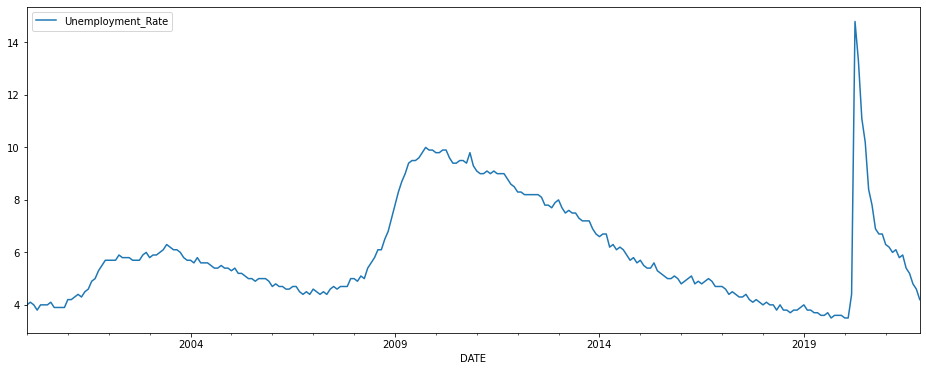

In [39]:
df_unempl = pdr.data.DataReader(name='UNRATE', data_source='fred', start = '2000-1-1', end = dt.date.today())
df_unempl.columns = ['Unemployment_Rate']
df_unempl.plot(figsize=(16, 6))
plt.show()

In [40]:
df_unempl.head()

,Unemployment_Rate
DATE,
2000-01-01,4.0
2000-02-01,4.1
2000-03-01,4.0
2000-04-01,3.8
2000-05-01,4.0


Change the frequency to weekly data, the missing values will be filled by existing values.

In [65]:
df_unempl_bfill = df_unempl.asfreq('W', method='bfill')
df_unempl_ffill = df_unempl.asfreq('W', method='ffill')
df_unempl_concat = pd.concat([df_unempl_bfill, df_unempl_ffill], axis=1)
df_unempl_concat.columns =['unemp_rate_bfilled_weekly', 'unemp_rate_ffilled_weekly']

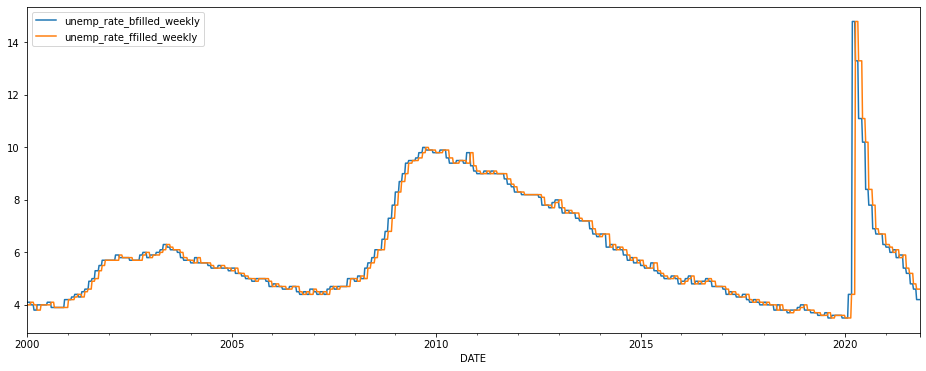

In [66]:
df_unempl_concat.plot(figsize=(16, 6)); plt.show()

## Interpolation

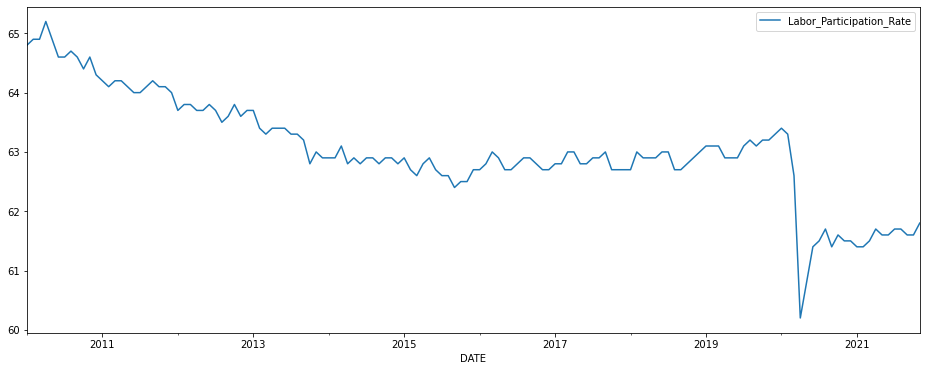

In [77]:
lab_part = pdr.data.DataReader(name='CIVPART', data_source='fred', start = '2010-1-1', end = dt.date.today())
lab_part.columns = ['Labor_Participation_Rate']
lab_part.plot(figsize=(16, 6))
plt.show()

In [91]:
daily_dates = pd.date_range(start=lab_part.index.min(), end=lab_part.index.max(), freq='D')

In [92]:
lab_part_daily = lab_part.reindex(daily_dates)
lab_part_daily['forward_fill'] = lab_part_daily['Labor_Participation_Rate'].ffill()
lab_part_daily['interpolation'] = lab_part_daily['Labor_Participation_Rate'].interpolate() # this is exactly the plot above

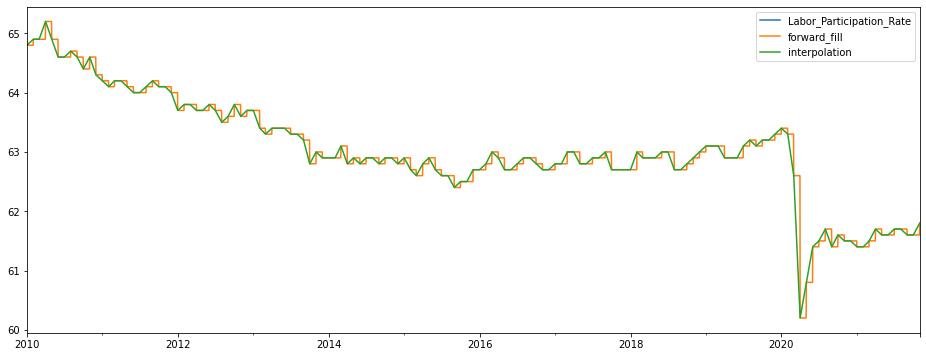

In [93]:
lab_part_daily.plot(figsize=(16, 6)); plt.show()

In [110]:
df = pdr.data.DataReader(name=['DFII10','GOLDAMGBD228NLBM'], data_source='fred', start = '2010-1-1', end = dt.date.today())

In [111]:
df.columns = ['10y_TB_yield','Gold_Fix_London_10AM']

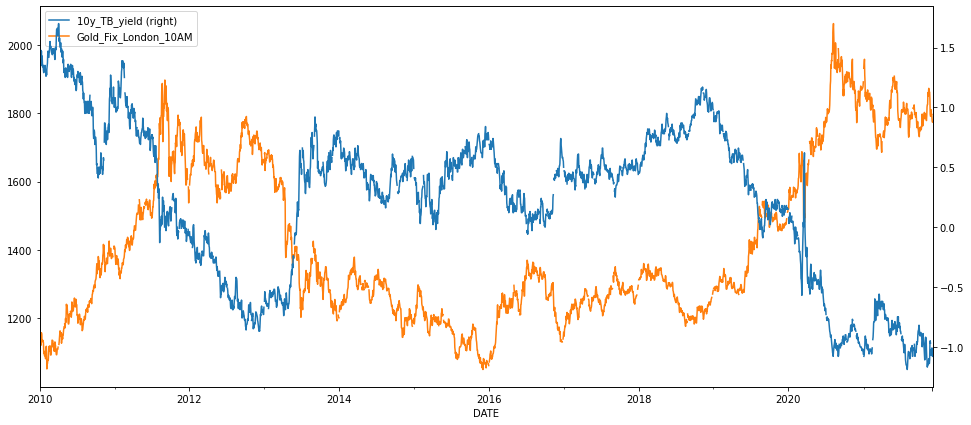

In [112]:
ax = df.plot(secondary_y = '10y_TB_yield', figsize =(16, 7))
plt.show()